# ***Cene*** - An Image Classification, Organisation Application

*Cene* is an image classification application that aims to classify images of 6 landscapes into corresponding albums.  The landscapes this app is capable of classifying are buildings, forests, glaciers, mountains, seas and streets.  While it is unrealistic that regular users would only have images of these 6 types on their devices, this project aims to create a proof-of-concept application to demonstrate deployment of machine learning image classification models.  

## Why does Image Classification Matter?

Image recognition is a key component of artificial intelligence.  It has wide practical applications in fields such as search engines, robotics, self-driving vehicles, identity recogition security systems and much more.

Image classification has also helped to improve organisation systems.  In the digital age, consumers are able to store thousands of images on their personal devices.  The task of manually sifting through personal photos to organise them into relevant categories is an impossible task for the everday user.  However, this process can be automated by employing machine learning models such as deep neural networks and convolutional neural networks.  

## The Data

The data used for this project was sourced from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification).  The data was intially published on [Analytics Vidhya]( https://datahack.analyticsvidhya.com) as an image classification challenge and the data was provided by Intel.  The owner of the dataset is [Puneet Bansal](https://www.kaggle.com/puneet6060).

The data consists of 24,034 building, forest, glacier, mountain, sea and street images.  The data is then split up into training and test sets which each contain 6 sub directories of the 6 image classes.  There are 14,034 images in the training set and 3,000 in the test set.  Further to this, the dataset contains 7,000 unlabelled images for predictive testing purposes.  For modeling purposes, the training set was further split in order to create a validation set.  

The file structure of the data directory in this repo and used for modeling throughout this project is as follows:
```
.
├── data
│   ├── seg_train
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_val
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_test
│   │   ├── buildings
│   │   ├── forest
│   │   ├── glacier
│   │   ├── mountain
│   │   ├── sea
│   │   ├── street
│   ├── seg_pred
```
**Note:**  When downloading the data from Kaggle, the zip file will only contain folders for `seg_train`, `seg_test` and `seg_pred`.  The details of how to create the validation set are provided later on in this notebook.  

## Data Preparation and EDA

### Imports

In [1]:
import os, shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

parent_dir = '../'

Using TensorFlow backend.


### Plotting Parameters

In [27]:
# plot params:
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['savefig.directory'] = parent_dir + '/figures/'

### Validation Set

Our data is currently split up into labeled train and test sets and then we also have access to an unlabeled 'prediction' set.  

We want to be able to validate our model without tapping into the labeled test set too early.  For this reason, we will take 20% of the training images and create a new directory in the data folder called `seg_val`.

First, we create filepath variables for each class in the training directory:

In [3]:
train_buildings_dir = parent_dir + 'data/seg_train/buildings'
train_forest_dir = parent_dir + 'data/seg_train/forest'
train_glacier_dir = parent_dir + 'data/seg_train/glacier'
train_mountain_dir = parent_dir + 'data/seg_train/mountain'
train_sea_dir = parent_dir + 'data/seg_train/sea'
train_street_dir = parent_dir + 'data/seg_train/street'

Next, we create variables to access the images of each class in the training data.  This will result in a list of strings of the image file names:

In [4]:
imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

Let's now view how many images of each class are in the training data to see if we have any class imablances:

In [7]:
scenes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
img_files = [imgs_buildings, imgs_forest, imgs_glacier, imgs_mountain, imgs_sea, imgs_street]
# let's create a dictionary containing the number of images per scene
num_imgs_dict = {}
for file, scene in zip(img_files, scenes):
    print('There are', len(file), f'{scene} images')
    num_imgs_dict[scene] = len(file)

There are 1753 buildings images
There are 1817 forest images
There are 1924 glacier images
There are 2010 mountain images
There are 1820 sea images
There are 1906 street images


At first glance, it appears like the classes are fairly balanced, but let's visualize this:

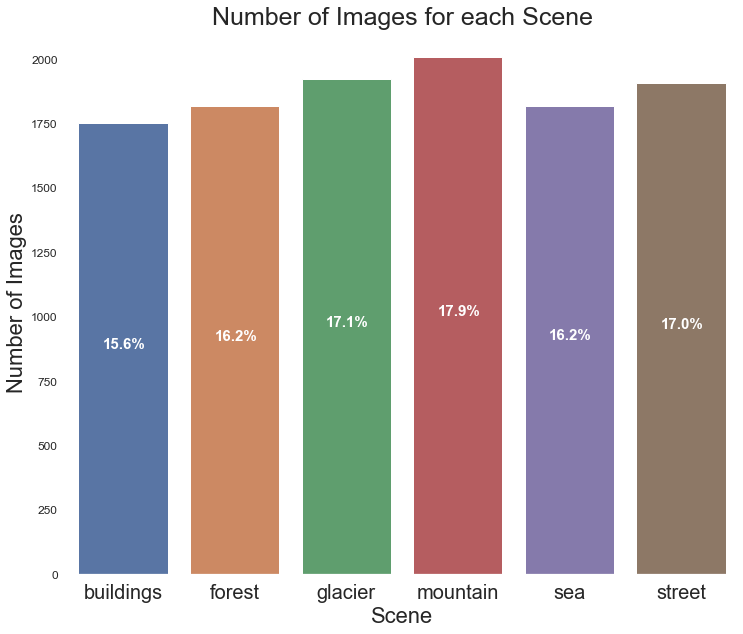

In [28]:
classes = list(num_imgs_dict.keys())
values = list(num_imgs_dict.values())

fig, ax = plt.subplots(figsize = (12, 10))
sns.set()
sns.set_style('white')
sns.color_palette("deep")
sns.barplot(classes, values)
total = np.sum(values)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x_ = p.get_x() + p.get_width() + 0.02
        y_ = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x_, y_), fontsize = 15, xytext = (x_-0.6, y_), color = 'white', fontweight = 'bold')
plt.title('Number of Images for each Scene', fontsize = 25)
plt.xlabel('Scene', fontsize = 22)
plt.ylabel('Number of Images', fontsize = 22)
plt.xticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/num_imgs_per_scene')
plt.show()

We see from this bar graph that we have relatively balanced classes with the mountain class containing the highest number of images and sea class containing the least.  

Now, let's get back to creating a new validation set.  We'll start by creating file paths for the train, test and validation sets:

In [29]:
val_folder = parent_dir + 'data/seg_val/'
test_folder = parent_dir + 'data/seg_test/'
train_folder = parent_dir + 'data/seg_train/'

Next, we create file path variables for the class folders within the `seg_val` directory:

In [30]:
val_buildings = os.path.join(val_folder, 'buildings')
val_forest = os.path.join(val_folder, 'forest')
val_glacier = os.path.join(val_folder, 'glacier')
val_mountain = os.path.join(val_folder, 'mountain')
val_sea = os.path.join(val_folder, 'sea')
val_street = os.path.join(val_folder, 'street')

Finally, let's actually create the validation directories:

In [46]:
# create the seg_val folder within the data directory
os.mkdir(val_folder)

# create the class labeled folders within the seg_val
os.mkdir(val_buildings)
os.mkdir(val_forest)
os.mkdir(val_glacier)
os.mkdir(val_mountain)
os.mkdir(val_sea)
os.mkdir(val_street)

### Train Test (Val) Split

Let's now perform the split for the validation set.  I'm going to choose an 80-20 split to make sure we don't dilute the training set too much.  Since each class has a different number of images, we create `_split_size` variables to contain 20% of the images of each class to make sure the class balances stay the same between training and validation sets:

In [32]:
# validation sets:
buildings_split_size = int(len(imgs_buildings) * 0.2)
forest_split_size = int(len(imgs_forest) * 0.2)
glacier_split_size = int(len(imgs_glacier) * 0.2)
mountain_split_size = int(len(imgs_mountain) * 0.2)
sea_split_size = int(len(imgs_sea) * 0.2)
street_split_size = int(len(imgs_street) * 0.2)

We will then randomly sample images from each class folder in the training set according to the above split sizes for each class:

In [34]:
buildings_val_set = random.sample(imgs_buildings, buildings_split_size)
forest_val_set = random.sample(imgs_forest, forest_split_size)
glacier_val_set = random.sample(imgs_glacier, glacier_split_size)
mountain_val_set = random.sample(imgs_mountain, mountain_split_size)
sea_val_set = random.sample(imgs_sea, sea_split_size)
street_val_set = random.sample(imgs_street, street_split_size)

Finally, we can move the randomly selected images from the training directory and into the validation directory:

In [74]:
# validation sets
val_sets = [buildings_val_set, forest_val_set, glacier_val_set, 
            mountain_val_set, sea_val_set, street_val_set]

# file paths of where the images currently live
train_locations = [train_buildings_dir, train_forest_dir, train_glacier_dir, 
                   train_mountain_dir, train_sea_dir, train_street_dir]

# file paths of where we want the images to go 
new_locations = [val_buildings, val_forest, val_glacier, 
               val_mountain, val_sea, val_street]

for val_set, train_location, new_location in zip(val_sets, train_locations, new_locations):
    for img in val_set:
        origin = os.path.join(train_location, img)  # where we will take the image from
        destination = os.path.join(new_location, img)  # where we want to move the image to
        shutil.move(origin, destination)

Now let's check that the images were really moved out of the train set and into the val set.  We'll do this by recounting the number of images in the training folders:

In [75]:
train_imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
train_imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
train_imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
train_imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
train_imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
train_imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

In [76]:
# let's create a dictionary containing the number of images per scene
new_train_imgs_dict = {}
for file, scene in zip(train_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    new_train_imgs_dict[scene] = len(file)

There are 1753 buildings images
There are 1817 forest images
There are 1924 glacier images
There are 2010 mountain images
There are 1820 sea images
There are 1906 street images


Compare this with original amount in training set:

In [78]:
num_imgs_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

Now let's check the move was correct for the validation set:

In [79]:
val_imgs_buildings = [file for file in os.listdir(val_buildings) if file.endswith('.jpg')]
val_imgs_forest = [file for file in os.listdir(val_forest) if file.endswith('.jpg')]
val_imgs_glacier = [file for file in os.listdir(val_glacier) if file.endswith('.jpg')]
val_imgs_mountain = [file for file in os.listdir(val_mountain) if file.endswith('.jpg')]
val_imgs_sea = [file for file in os.listdir(val_sea) if file.endswith('.jpg')]
val_imgs_street = [file for file in os.listdir(val_street) if file.endswith('.jpg')]

val_img_files = [val_imgs_buildings, val_imgs_forest, val_imgs_glacier, 
             val_imgs_mountain, val_imgs_sea, val_imgs_street]

# let's create a dictionary containing the number of images per scene
len_val_imgs_dict = {}
for file, scene in zip(val_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    len_val_imgs_dict[scene] = len(file)

There are 438 buildings images
There are 454 forest images
There are 480 glacier images
There are 502 mountain images
There are 454 sea images
There are 476 street images


So, we now have a validation set with 20% of the training images.  We'll be able to use this for our modelling and keep our test set clean. 

Finally, let's see how many images we have in training, test, and validation:

In [108]:
# training
sum(list(new_train_imgs_dict.values()))

11230

In [109]:
# validation
sum(list(len_val_imgs_dict.values()))

2804

And we know there are 3000 in the test set (as mentioned in the introduction).